In [7]:
import yfinance as yf
import pandas as pd
import xlrd
import cvxpy as cp
import numpy as np
import time
import tqdm
import logging
import warnings

# Data Procurement

### Symbol Procurement

In [15]:
nasdaq_df = pd.read_csv("ftp://ftp.nasdaqtrader.com/SymbolDirectory/nasdaqlisted.txt", sep="|")
other_df = pd.read_csv("ftp://ftp.nasdaqtrader.com/SymbolDirectory/otherlisted.txt", sep="|")

In [3]:
filtered_nasdaq_df = nasdaq_df[
    (nasdaq_df["Test Issue"] == "N") & # Excluding Test Issues
    (nasdaq_df["ETF"] == "N") & # Excluding ETFS
    (nasdaq_df["NextShares"] == "N") & # Excluding NextShares
    (nasdaq_df["Financial Status"] == "N") # Normal Stocks
]

# Split "Name - Description" into different columns

filtered_nasdaq_df = filtered_nasdaq_df.copy()
filtered_nasdaq_df[['Name', 'Description']] = filtered_nasdaq_df['Security Name'].str.split(' - ', n=1, expand=True)
filtered_nasdaq_df['Name'] = filtered_nasdaq_df['Name'].str.strip()
filtered_nasdaq_df['Description'] = filtered_nasdaq_df['Description'].str.strip()
filtered_nasdaq_df['Description'] = filtered_nasdaq_df['Description'].fillna("")

# Additional filter to ensure stocks are pure common equity

print("NASDAQ stocks before last filter:", filtered_nasdaq_df.shape[0])

exclusions_nasdaq_df = filtered_nasdaq_df[filtered_nasdaq_df["Description"].str.contains(
    r"\bETF\b|\bFund\b|\bPreferred\b|\bWarrant\b|\bNote\b|\bTrust\b|\bDepositary\b|\bBond\b|\bRight\b", case=False, regex=True 
)]

filtered_nasdaq_df = filtered_nasdaq_df[~filtered_nasdaq_df["Description"].str.contains(
    r"\bETF\b|\bFund\b|\bPreferred\b|\bWarrant\b|\bNote\b|\bTrust\b|\bDepositary\b|\bBond\b|\bRight\b", case=False, regex=True 
)]

print("NASDAQ stocks after excluded filter:", filtered_nasdaq_df.shape[0])

print("\nMost commonly excluded NASDAQ securities:")
display(exclusions_nasdaq_df["Description"].value_counts().head(5))

NASDAQ stocks before last filter: 3806
NASDAQ stocks after excluded filter: 3244

Most commonly excluded NASDAQ securities:


Description
Warrant                       206
American Depositary Shares    137
Closed End Fund                33
Right                          30
American Depositary Share       4
Name: count, dtype: int64

In [4]:
filtered_other_df = other_df[
    (other_df["Test Issue"] == "N") & # Excluding Test Issues
    (other_df["ETF"] == "N") # Excluding ETFS
]

# This dataset does not have the same Name - Description format, so obtaining a description is more difficult. A less strict filter is therefore used.

print("OTHER stocks before last filter:", filtered_other_df.shape[0])

exclusions_other_df = filtered_other_df[filtered_other_df["Security Name"].str.contains(
    r"\bETF\b|\bWarrant\b|\bNote\b|\bDepositary\b|\bRight\b", case=False, regex=True
)]

filtered_other_df = filtered_other_df[~filtered_other_df["Security Name"].str.contains(
    r"\bETF\b|\bWarrant\b|\bNote\b|\bDepositary\b|\bRight\b", case=False, regex=True
)]

print("OTHER stocks after last filter:", filtered_other_df.shape[0])

OTHER stocks before last filter: 3147
OTHER stocks after last filter: 2827


In [16]:
nasdaq_symbols = nasdaq_df["Symbol"].unique().tolist()
other_symbols = other_df["ACT Symbol"].unique().tolist()

print("Total NASDAQ symbols:", len(nasdaq_symbols))
print("Total OTHER symbols:", len(other_symbols))

total_symbols = set(nasdaq_symbols + other_symbols)
print("Total symbols:", len(total_symbols))


Total NASDAQ symbols: 5138
Total OTHER symbols: 6744
Total symbols: 11881


In [17]:
logging.getLogger("yfinance").setLevel(logging.CRITICAL)
warnings.filterwarnings("ignore")


market_cap = {}
quote_type = {}
asset_type = {}

i = 0
for symbol in tqdm.tqdm(total_symbols):
    try:
        info = yf.Ticker(symbol).info
        
        market_cap[symbol] = info.get("marketCap")
        quote_type[symbol] = info.get("quoteType")
        asset_type[symbol] = info.get("assetType")

    except Exception as e:
        print(f"Error fetching data for {symbol}: {e}")
        
    if i % 100 == 0:
        time.sleep(1)   
    
    i += 1

 35%|███▌      | 4183/11881 [30:34<52:29,  2.44it/s]  

Error fetching data for nan: 'float' object has no attribute 'upper'


 54%|█████▍    | 6474/11881 [47:51<13:57:25,  9.29s/it]

Error fetching data for ZBRA: Failed to perform, curl: (28) Operation timed out after 30011 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.


 54%|█████▍    | 6475/11881 [48:21<23:17:21, 15.51s/it]

Error fetching data for JANW: Failed to perform, curl: (28) Operation timed out after 30010 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.


 55%|█████▍    | 6476/11881 [48:51<29:49:17, 19.86s/it]

Error fetching data for SVCC: Failed to perform, curl: (28) Operation timed out after 30014 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.


 55%|█████▍    | 6477/11881 [49:21<34:23:16, 22.91s/it]

Error fetching data for PDP: Failed to perform, curl: (28) Operation timed out after 30011 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.


 55%|█████▍    | 6478/11881 [49:51<37:35:01, 25.04s/it]

Error fetching data for QUIZ: Failed to perform, curl: (28) Operation timed out after 30011 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.


 55%|█████▍    | 6479/11881 [50:21<39:48:53, 26.53s/it]

Error fetching data for SYK: Failed to perform, curl: (28) Operation timed out after 30010 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.


 55%|█████▍    | 6480/11881 [50:51<41:22:44, 27.58s/it]

Error fetching data for BWAY: Failed to perform, curl: (28) Operation timed out after 30005 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.


 55%|█████▍    | 6481/11881 [51:21<42:27:43, 28.31s/it]

Error fetching data for OTLY: Failed to perform, curl: (28) Operation timed out after 30001 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.


 55%|█████▍    | 6482/11881 [51:51<43:13:08, 28.82s/it]

Error fetching data for DAT: Failed to perform, curl: (28) Operation timed out after 30005 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.


 55%|█████▍    | 6483/11881 [52:21<43:44:58, 29.18s/it]

Error fetching data for ARCO: Failed to perform, curl: (28) Operation timed out after 30012 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.


 55%|█████▍    | 6484/11881 [52:51<44:06:58, 29.43s/it]

Error fetching data for SBEV: Failed to perform, curl: (28) Operation timed out after 30008 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.


 55%|█████▍    | 6485/11881 [53:21<44:22:10, 29.60s/it]

Error fetching data for TRTN$C: Failed to perform, curl: (28) Operation timed out after 30005 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.


 55%|█████▍    | 6486/11881 [53:51<44:32:56, 29.73s/it]

Error fetching data for ETQ: Failed to perform, curl: (28) Operation timed out after 30014 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.


 55%|█████▍    | 6487/11881 [54:21<44:40:19, 29.81s/it]

Error fetching data for DYCQ: Failed to perform, curl: (28) Operation timed out after 30007 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.


 55%|█████▍    | 6488/11881 [54:51<44:45:08, 29.87s/it]

Error fetching data for FLUD: Failed to perform, curl: (28) Operation timed out after 30007 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.


 55%|█████▍    | 6489/11881 [55:21<44:48:30, 29.92s/it]

Error fetching data for NLOP: Failed to perform, curl: (28) Operation timed out after 30014 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.


 55%|█████▍    | 6490/11881 [55:51<44:50:25, 29.94s/it]

Error fetching data for CODA: Failed to perform, curl: (28) Operation timed out after 30004 milliseconds with 0 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.


100%|██████████| 11881/11881 [1:37:23<00:00,  2.03it/s] 


In [18]:
# combine them into a DataFrame
output_df2 = pd.DataFrame({
    "market_cap": market_cap,
    "quote_type": quote_type,
    "asset_type": asset_type
})

# move tickers from index to column
output_df2.index.name = "symbol"
output_df2.reset_index(inplace=True)

# export to JSON
output_df2.to_json("market_data2.json", orient="records", indent=2)
display(output_df2)

symbol    market_cap  quote_type asset_type
0        USOY           NaN         ETF       None
1      PRIF$J           NaN        None       None
2        RAMP  1.785779e+09      EQUITY       None
3        TRVG  2.170149e+08      EQUITY       None
4         GIC  1.312018e+09      EQUITY       None
...       ...           ...         ...        ...
11858   LEN.B           NaN  MUTUALFUND       None
11859     PEG  4.209238e+10      EQUITY       None
11860    AIZN           NaN      EQUITY       None
11861     EXE  2.347878e+10      EQUITY       None
11862     ILF  1.342730e+09         ETF       None

[11863 rows x 4 columns]

In [19]:
print(output_df2["quote_type"].value_counts())

quote_type
EQUITY        6940
ETF           4402
MUTUALFUND       9
NONE             3
Name: count, dtype: int64


In [27]:
exceptions = output_df2[
    output_df2["market_cap"].isna() & (output_df2["quote_type"] == "EQUITY")
]
exceptions

symbol  market_cap quote_type asset_type
15     BRLSW         NaN     EQUITY       None
36     OXLCL         NaN     EQUITY       None
43     IPODW         NaN     EQUITY       None
48       HYP         NaN     EQUITY       None
49     LFMDP         NaN     EQUITY       None
...      ...         ...        ...        ...
11820  AFJKU         NaN     EQUITY       None
11835  TALKW         NaN     EQUITY       None
11850    ZAP         NaN     EQUITY       None
11851   BSMZ         NaN     EQUITY       None
11860   AIZN         NaN     EQUITY       None

[991 rows x 4 columns]

In [ ]:
nasdaq_df[nasdaq_df["Symbol"].isin()]

Symbol  \
0                                  AACB   
1                                 AACBR   
2                                 AACBU   
3                                  AACG   
4                                  AACI   
...                                 ...   
5133                               ZYBT   
5134                               ZYME   
5135                                ZYN   
5136                               ZYXI   
5137  File Creation Time: 1016202518:01   

                                          Security Name Market Category  \
0     Artius II Acquisition Inc. - Class A Ordinary ...               G   
1                   Artius II Acquisition Inc. - Rights               G   
2                    Artius II Acquisition Inc. - Units               G   
3     ATA Creativity Global - American Depositary Sh...               S   
4     Armada Acquisition Corp. II - Class A Ordinary...               G   
...                                                 ...             ...   
5133  Zhengye Biotechnology Holding Limited - Ordina...               S   
5134                      Zymeworks Inc. - Common Stock               Q   
5135               Defiance Daily Target 2x Long PM ETF               G   
5136                         Zynex, Inc. - Common Stock               Q   
5137                                                NaN             NaN   

     Test Issue Financial Status  Round Lot Size  ETF NextShares  
0             N                N           100.0    N          N  
1             N                N           100.0    N          N  
2             N                N           100.0    N          N  
3             N                N           100.0    N          N  
4             N                N           100.0    N          N  
...         ...              ...             ...  ...        ...  
5133          N                N           100.0    N          N  
5134          N                N           100.0    N          N  
5135          N                N           100.0    Y          N  
5136          N                N           100.0    N          N  
5137        NaN              NaN             NaN  NaN        NaN  

[5138 rows x 8 columns]

In [31]:
# dict to dataframe

market_cap_df = pd.DataFrame(list(market_cap.items()), columns=["Symbol", "MarketCap"])
market_cap_df = market_cap_df.dropna()
market_cap_df = market_cap_df.sort_values(by="MarketCap", ascending=False)
market_cap_df_1000 = market_cap_df.head(1000)
market_cap_df_1000

Symbol     MarketCap
1923   NVDA  4.604262e+12
1787   MSFT  3.901297e+12
9      AAPL  3.829711e+12
1154   GOOG  2.962996e+12
1155  GOOGL  2.962996e+12
...     ...           ...
1780   MRTN  9.016159e+08
1357   INDI  9.014264e+08
352    BHRB  9.010470e+08
70     AEVA  9.001165e+08
2590   SWIM  8.950429e+08

[1000 rows x 2 columns]

In [33]:
tickers_1000 = market_cap_df_1000["Symbol"].tolist()

In [ ]:

historical_data = yf.download(
    tickers=tickers_1000,
    start="2021-10-08",
    end="2025-10-08",
    interval="1d",
    group_by='ticker',
    auto_adjust=True,
    progress=True
)

[*********************100%***********************]  1000 of 1000 completed


In [ ]:
historical_data_reset = historical_data.reset_index()
historical_data_reset.to_parquet("historical_data_1000_reset.parquet", engine='fastparquet')


# Load Data

In [3]:
historical_data = pd.read_parquet("historical_data_1000_reset.parquet", engine="fastparquet")
historical_data = historical_data.set_index("Date")  # put date back as index
historical_data

Ticker            NOVT                                                    BGM  \
Price             Open        High         Low       Close  Volume       Open   
Date                                                                            
2021-10-08  158.350006  162.059998  157.210007  161.429993  103900  18.835739   
2021-10-11  161.149994  161.149994  158.229996  159.000000   76600  19.049231   
2021-10-12  160.059998  161.360001  158.360001  158.839996   58900  18.971597   
2021-10-13  160.020004  160.020004  157.539993  159.669998   41600  18.908521   
2021-10-14  161.860001  162.979996  161.320007  162.960007   89400  19.073493   
...                ...         ...         ...         ...     ...        ...   
2025-10-01   99.410004  101.339996   99.410004  100.820000  320400  10.400000   
2025-10-02  100.919998  103.510002  100.660004  103.250000  385000   9.767000   
2025-10-03  103.809998  106.250000  103.809998  104.529999  377000   9.870000   
2025-10-06  104.879997  105.809998  102.480003  104.320000  465400   9.325000   
2025-10-07  105.120003  105.300003  100.739998  100.970001  281700   9.410000   

Ticker                                              ...       CYTK             \
Price            High        Low      Close Volume  ...       Open       High   
Date                                                ...                         
2021-10-08  19.602367  18.830888  19.602367   2660  ...  39.169998  39.259998   
2021-10-11  19.510178  18.826036  18.826036    800  ...  37.720001  38.580002   
2021-10-12  19.505326  18.927929  19.214201   1500  ...  36.840000  37.040001   
2021-10-13  19.311242  18.908521  19.165680   1440  ...  36.880001  38.270000   
2021-10-14  19.165682  19.068640  19.068640    880  ...  38.490002  38.990002   
...               ...        ...        ...    ...  ...        ...        ...   
2025-10-01  10.480000  10.113000  10.200000  21700  ...  55.119999  56.080002   
2025-10-02  10.310000   9.740000  10.175000   5300  ...  56.160000  56.689999   
2025-10-03  10.570000   9.550000   9.570000  13800  ...  56.740002  58.790001   
2025-10-06   9.905000   9.325000   9.905000  10300  ...  57.869999  61.000000   
2025-10-07   9.690000   9.360000   9.690000   3200  ...  60.560001  61.189999   

Ticker                                            CME                          \
Price             Low      Close   Volume        Open        High         Low   
Date                                                                            
2021-10-08  37.740002  38.009998   840300  169.403540  170.371844  167.029072   
2021-10-11  36.189999  36.259998   775200  170.649688  172.081098  169.193018   
2021-10-12  36.000000  36.709999   472400  169.513010  171.601186  169.176199   
2021-10-13  36.520000  37.980000   481800  169.908750  172.367424  167.980558   
2021-10-14  37.340000  38.130001   617400  172.123238  174.489278  171.104416   
...               ...        ...      ...         ...         ...         ...   
2025-10-01  53.610001  55.840000  2066500  270.190002  270.519989  264.100006   
2025-10-02  55.330002  56.320000  2004600  264.540009  266.029999  262.260010   
2025-10-03  56.200001  56.970001  2457700  265.429993  266.410004  264.459991   
2025-10-06  57.279999  60.639999  3020500  264.119995  264.220001  258.190002   
2025-10-07  58.740002  60.169998  1784900  263.959991  264.750000  261.450012   

Ticker                           
Price            Close   Volume  
Date                             
2021-10-08  169.689819  1170300  
2021-10-11  169.512985   929300  
2021-10-12  170.767593  1077000  
2021-10-13  171.988510  1540300  
2021-10-14  174.337723  1314500  
...                ...      ...  
2025-10-01  265.839996  2308900  
2025-10-02  265.429993  1646200  
2025-10-03  264.670013  1715100  
2025-10-06  262.049988  2190600  
2025-10-07  263.600006  1628600  

[1003 rows x 5000 columns]

In [4]:
market_close_df = historical_data[[col for col in historical_data.columns if col[1] == 'Close']]
market_close_df.columns = [col[0] for col in market_close_df.columns]
market_close_df.describe()
market_close_df = market_close_df.dropna(thresh=market_close_df.shape[0]-50, axis=1)
market_close_df = market_close_df.interpolate(axis=1)
market_returns_df = market_close_df.pct_change().drop(index = market_close_df.index[0])

In [5]:
files = [f"historyIndex ({i}).xls" for i in range(1, 5)]

dates_list, values_list, names = [], [], []

for file in files:
    book = xlrd.open_workbook(file)
    sheet = book.sheet_by_index(0)

    name = None
    dates, values = [], []
    table_started = False

    for r in range(sheet.nrows):
        cell = sheet.row(r)[0].value

        if not table_started and cell == 'Date':
            name = sheet.row(r)[1].value
            table_started = True
        elif table_started and cell != '':
            dates.append(cell)
            values.append(sheet.row(r)[1].value)
        else:
            table_started = False

    names.append(name)
    dates_list.append(dates)
    values_list.append(values)

data = {'Date': dates_list[0], **{n: v for n, v in zip(names, values_list)}}
index_gross_df = pd.DataFrame(data)

for n in names:
    index_gross_df[n] = (pd.to_numeric(index_gross_df[n].astype(str).str.replace(',', ''), errors='coerce'))

index_gross_df['Date'] = pd.to_datetime(index_gross_df['Date'])
index_gross_df = index_gross_df[index_gross_df['Date'].isin(market_close_df.index)]
index_gross_df = index_gross_df.set_index('Date')
index_returns_df = index_gross_df.pct_change().drop(index = index_gross_df.index[0])
index_gross_df.head(5)

USA Standard (Large+Mid Cap)  \
Date                                       
2021-10-08                     19401.738   
2021-10-11                     19268.835   
2021-10-12                     19238.964   
2021-10-13                     19320.676   
2021-10-14                     19649.436   

            USA QUALITY Standard (Large+Mid Cap)  \
Date                                               
2021-10-08                              4411.446   
2021-10-11                              4381.008   
2021-10-12                              4360.148   
2021-10-13                              4381.408   
2021-10-14                              4469.621   

            USA MOMENTUM Standard (Large+Mid Cap)  \
Date                                                
2021-10-08                               4389.119   
2021-10-11                               4354.444   
2021-10-12                               4358.168   
2021-10-13                               4375.509   
2021-10-14                               4459.911   

            MSCI USA Focus Index Standard (Large+Mid Cap)  
Date                                                       
2021-10-08                                       4785.092  
2021-10-11                                       4754.493  
2021-10-12                                       4747.528  
2021-10-13                                       4767.287  
2021-10-14                                       4851.782

In [6]:
market_close_df.head(5)

NOVT        BGM        NVMI       LBRDK       PRDO  EVLV  \
Date                                                                         
2021-10-08  161.429993  19.602367   97.190002  157.771530  10.737411  5.49   
2021-10-11  159.000000  18.826036   99.430000  155.908234  10.604026  5.41   
2021-10-12  158.839996  19.214201   98.720001  154.700378  10.270565  5.34   
2021-10-13  159.669998  19.165680  100.300003  154.962540  10.222929  5.30   
2021-10-14  162.960007  19.068640  103.660004  157.237823  10.337258  5.53   

             IMTX       HWKN      IMKTA        ICUI  ...        CPB  \
Date                                                 ...              
2021-10-08  13.40  35.577824  65.902946  228.110001  ...  36.723419   
2021-10-11  13.38  35.587433  65.147575  224.820007  ...  36.427616   
2021-10-12  13.55  35.875511  65.902946  230.589996  ...  36.331921   
2021-10-13  13.85  35.645046  65.893272  231.750000  ...  36.114403   
2021-10-14  14.16  36.470879  65.515572  234.119995  ...  36.097015   

                 NSIT       ACHC       VITL       CFLT       VRNT       CARG  \
Date                                                                           
2021-10-08  91.760002  58.119999  17.790001  64.589996  45.910000  34.689999   
2021-10-11  91.919998  56.419998  17.440001  60.360001  45.619999  33.810001   
2021-10-12  91.830002  56.220001  17.700001  63.720001  46.299999  34.009998   
2021-10-13  91.870003  55.150002  17.959999  66.500000  46.669998  34.490002   
2021-10-14  94.129997  55.709999  17.930000  67.449997  46.669998  35.060001   

                 STEP       CYTK         CME  
Date                                          
2021-10-08  36.698826  38.009998  169.689819  
2021-10-11  37.047230  36.259998  169.512985  
2021-10-12  36.895351  36.709999  170.767593  
2021-10-13  37.082962  37.980000  171.988510  
2021-10-14  38.440857  38.130001  174.337723  

[5 rows x 899 columns]

In [7]:
index_returns_df.head(5)

USA Standard (Large+Mid Cap)  \
Date                                       
2021-10-11                     -0.006850   
2021-10-12                     -0.001550   
2021-10-13                      0.004247   
2021-10-14                      0.017016   
2021-10-15                      0.007194   

            USA QUALITY Standard (Large+Mid Cap)  \
Date                                               
2021-10-11                             -0.006900   
2021-10-12                             -0.004761   
2021-10-13                              0.004876   
2021-10-14                              0.020133   
2021-10-15                              0.006388   

            USA MOMENTUM Standard (Large+Mid Cap)  \
Date                                                
2021-10-11                              -0.007900   
2021-10-12                               0.000855   
2021-10-13                               0.003979   
2021-10-14                               0.019290   
2021-10-15                               0.011660   

            MSCI USA Focus Index Standard (Large+Mid Cap)  
Date                                                       
2021-10-11                                      -0.006395  
2021-10-12                                      -0.001465  
2021-10-13                                       0.004162  
2021-10-14                                       0.017724  
2021-10-15                                       0.007062

In [8]:
market_returns_df.head(5)

NOVT       BGM      NVMI     LBRDK      PRDO      EVLV  \
Date                                                                     
2021-10-11 -0.015053 -0.039604  0.023048 -0.011810 -0.012422 -0.014572   
2021-10-12 -0.001006  0.020618 -0.007141 -0.007747 -0.031447 -0.012939   
2021-10-13  0.005225 -0.002525  0.016005  0.001695 -0.004638 -0.007491   
2021-10-14  0.020605 -0.005063  0.033500  0.014683  0.011184  0.043396   
2021-10-15 -0.008898  0.007634  0.001640 -0.005478  0.000922  0.014467   

                IMTX      HWKN     IMKTA      ICUI  ...       CPB      NSIT  \
Date                                                ...                       
2021-10-11 -0.001493  0.000270 -0.011462 -0.014423  ... -0.008055  0.001744   
2021-10-12  0.012706  0.008095  0.011595  0.025665  ... -0.002627 -0.000979   
2021-10-13  0.022140 -0.006424 -0.000147  0.005031  ... -0.005987  0.000436   
2021-10-14  0.022383  0.023168 -0.005732  0.010227  ... -0.000481  0.024600   
2021-10-15 -0.021893  0.010005 -0.008869 -0.014010  ... -0.007954  0.001487   

                ACHC      VITL      CFLT      VRNT      CARG      STEP  \
Date                                                                     
2021-10-11 -0.029250 -0.019674 -0.065490 -0.006317 -0.025367  0.009494   
2021-10-12 -0.003545  0.014908  0.055666  0.014906  0.005915 -0.004100   
2021-10-13 -0.019032  0.014689  0.043628  0.007991  0.014114  0.005085   
2021-10-14  0.010154 -0.001670  0.014286  0.000000  0.016527  0.036618   
2021-10-15  0.021181 -0.001673 -0.008154 -0.003214 -0.011409  0.000465   

                CYTK       CME  
Date                            
2021-10-11 -0.046041 -0.001042  
2021-10-12  0.012410  0.007401  
2021-10-13  0.034595  0.007150  
2021-10-14  0.003949  0.013659  
2021-10-15 -0.032520  0.023424  

[5 rows x 899 columns]

# Optimization

In [132]:
A = market_returns_df.values
b = index_returns_df["USA Standard (Large+Mid Cap)"].values
n = A.shape[0]
m = A.shape[1]
print(n, m)

A_close = market_close_df.values
b_gross = index_gross_df["USA Standard (Large+Mid Cap)"].values
real_dates = index_returns_df.index
initial_value = b_gross[0]

1002 899


## Naive

MSE: 5.70536464356956e-05
MAE: 0.005942232134694736


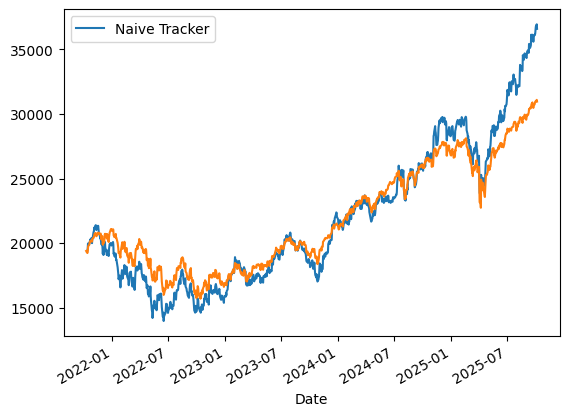

In [137]:
equal_weights = [1/m]*m
naive_tracker_returns = A @ equal_weights
naive_tracker_value = initial_value * (1 + naive_tracker_returns).cumprod()
naive_tracker_value_df = pd.DataFrame({"Naive Tracker": naive_tracker_value}, index=real_dates)
naive_tracker_value_df.plot()
index_gross_df["USA Standard (Large+Mid Cap)"].plot()

MSE = 0
MAE = 0
for i in range(n):
    MSE += (naive_tracker_returns[i] - b[i])**2
    MAE += abs(naive_tracker_returns[i] - b[i])

MSE /= n
MAE /= n

print("MSE:", MSE)
print("MAE:", MAE)

In [139]:
w = cp.Variable(A.shape[1])

objective = cp.Minimize(cp.sum_squares(A @ w - b))
constraints = [0 <= w, cp.sum(w) == 1]
prob = cp.Problem(objective, constraints)

print("Optimal objective value", prob.solve())

Optimal objective value 0.0014913341360280213


MSE: 1.4991556825577504e-06
MAE: 0.0009631806784585207


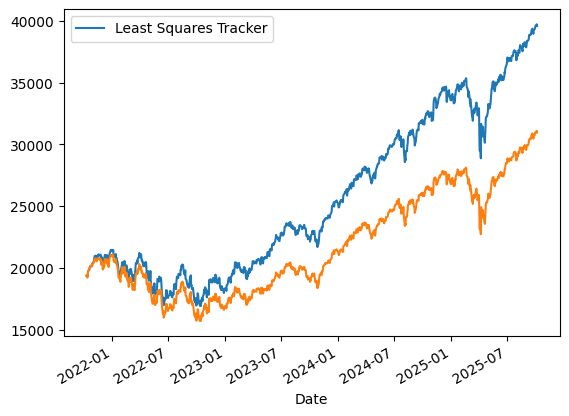

In [142]:
ls_weights = np.clip(w.value, 0, 1)
ls_weights /= sum(ls_weights)
ls_tracker_returns = A @ ls_weights
ls_tracker_value = initial_value * (1 + ls_tracker_returns).cumprod()
ls_tracker_value_df = pd.DataFrame({"Least Squares Tracker": ls_tracker_value}, index=real_dates)
ls_tracker_value_df.plot()
index_gross_df["USA Standard (Large+Mid Cap)"].plot()

MSE = 0
MAE = 0
for i in range(n):
    MSE += (ls_tracker_returns[i] - b[i])**2
    MAE += abs(ls_tracker_returns[i] - b[i])

MSE /= n
MAE /= n

print("MSE:", MSE)
print("MAE:", MAE)
